In [180]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set Trial Name

In [135]:
TRIAL_NAME = "1_first_sub"

import datetime
import pytz
NOW = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')

# Load yaml

In [136]:
import yaml
CONFIG_DIR = '../config'
with open(f'{CONFIG_DIR}/run000.yml') as file:
    cfg = yaml.safe_load(file)

import sys
sys.path.append(cfg['SRC_DIR'])
cfg['run_name'] = TRIAL_NAME

# fix seed

In [137]:
from util import seed_everything
seed_everything(seed=33, use_torch=False)

# Make Output Folder

In [138]:
import os
OUTPUT_DIR = f'../../output/{NOW}_{TRIAL_NAME}'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Model

In [139]:
import pandas as pd
sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')
color = pd.read_csv('../../data/color.csv')
historical_person = pd.read_csv('../../data/historical_person.csv')
maker = pd.read_csv('../../data/maker.csv')
material = pd.read_csv('../../data/material.csv')
object_collection = pd.read_csv('../../data/object_collection.csv')
palette = pd.read_csv('../../data/palette.csv')
principal_maker_occupation = pd.read_csv('../../data/principal_maker_occupation.csv')
principal_maker = pd.read_csv('../../data/principal_maker.csv')
production_place = pd.read_csv('../../data/production_place.csv')
technique = pd.read_csv('../../data/technique.csv')
test = pd.read_csv('../../data/test.csv')
train = pd.read_csv('../../data/train.csv')

# train

In [140]:
train.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2


In [141]:
test.head(2)

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late
0,000405d9a5e3f49fc49d,a2aabd3cc8859f4260ad,Twee personen voor de Duizendjarige den te Wol...,NaN,Twee personen voor de Duizendjarige den te Wol...,Bernardus Bruining,Bernardus Bruining,h 167mm × w 108mm,NaN,Twee personen voor de Duizendjarige den te Wol...,transfer,1994-01-01T00:00:00,NaN,1850 - 1900,1850.0,19,1850.0,1900.0
1,001020bd00b149970f78,5d6a286cc3ab64c2c043,"Portrait of Philipp Ernst, Count of Hohenlohe ...","Portret van Philip Ernst (1585-1629), graaf va...","Portrait of Philipp Ernst, Count of Hohenlohe ...",Jan Antonisz van Ravesteyn,Jan Antonisz van Ravesteyn,h 29.7cm × w 24.1cm,NaN,"Portrait of Philipp Ernst, Count of Hohenlohe ...",nationalization 1795,1798-09-01T00:00:00,NaN,c. 1609 - c. 1633,1609.0,17,1609.0,1633.0


In [142]:
# import sweetviz as sv

# #最後の引数には目的変数を指定
# my_report = sv.compare([train, "Train"], [test, "Test"], "likes")
 
# #直接ブラウザに表示
# my_report.show_html("Report.html")

# reduce mem usage

In [143]:
# from util import reduce_mem_usage
# train_feat_df = reduce_mem_usage(train_feat_df)
# test_feat_df = reduce_mem_usage(test_feat_df)

# del not common value between train and test

In [144]:
train.columns

Index(['object_id', 'art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late', 'likes'],
      dtype='object')

In [145]:
del_non_overlapping_list = [
    'object_id',
    'art_series_id',
    'title',
    'description',
    'long_title',
    'principal_maker',
    'principal_or_first_maker',
    'sub_title',
    'copyright_holder',
    'more_title',
    'acquisition_method',
    'acquisition_date',
    'acquisition_credit_line',
    'dating_presenting_date',
    'dating_sorting_date',
    'dating_period',
    'dating_year_early',
    'dating_year_late'
]

from util import replace_non_overlap_val_to_missing
train, test = replace_non_overlap_val_to_missing(train,test,columns=del_non_overlapping_list)

# Lable Encoding

In [146]:
cat_col = train.select_dtypes('O').columns.tolist()

In [147]:
from fe import label_encode
train, test = label_encode(train, test, cat_col)

In [148]:
train.dtypes

object_id                     int64
art_series_id                 int64
title                         int64
description                   int64
long_title                    int64
principal_maker               int64
principal_or_first_maker      int64
sub_title                     int64
copyright_holder              int64
more_title                    int64
acquisition_method            int64
acquisition_date              int64
acquisition_credit_line       int64
dating_presenting_date        int64
dating_sorting_date         float64
dating_period                 int64
dating_year_early           float64
dating_year_late            float64
likes                         int64
dtype: object

# add fold

In [149]:
from fold import add_fold_kf
train = add_fold_kf(train,fold_num=5)

# Make Model

In [150]:
use_col = train.columns.tolist()
use_col.remove('fold')
use_col.remove(cfg['target'])

In [151]:
use_col

['object_id',
 'art_series_id',
 'title',
 'description',
 'long_title',
 'principal_maker',
 'principal_or_first_maker',
 'sub_title',
 'copyright_holder',
 'more_title',
 'acquisition_method',
 'acquisition_date',
 'acquisition_credit_line',
 'dating_presenting_date',
 'dating_sorting_date',
 'dating_period',
 'dating_year_early',
 'dating_year_late']

In [152]:
# 学習直前でwandbにログイン、こうしないと頻繁にnotebookが落ちる
from use_wandb import use_wandb
use_wandb(params=cfg['params'], PROJECT_NAME=cfg['competition_name'], TRIAL_NAME=TRIAL_NAME)

likes_fold0_rmsle,3.23708
_runtime,1517
_timestamp,1614963142
_step,130
likes_fold1_rmsle,3.28272
likes_fold2_rmsle,3.30101
likes_fold3_rmsle,3.2707
likes_fold4_rmsle,3.29455
likes_all_rmsle,3.27729


likes_fold0_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
_timestamp,▁▁▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
likes_fold1_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
likes_fold2_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
likes_fold3_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
likes_fold4_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
likes_all_rmsle,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


--------------FOLDS : 0 --------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 578.134	valid_1's rmse: 664.432


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[200]	training's rmse: 550.26	valid_1's rmse: 666.902
Early stopping, best iteration is:
[100]	training's rmse: 578.134	valid_1's rmse: 664.432
Fold 0 rmsle: 2.7580
--------------FOLDS : 1 --------------
Training until validation scores don't improve for 100 rounds


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 565.012	valid_1's rmse: 721.022
[200]	training's rmse: 538.552	valid_1's rmse: 717.147
[300]	training's rmse: 517.114	valid_1's rmse: 715.698
Early stopping, best iteration is:
[298]	training's rmse: 517.503	valid_1's rmse: 715.657
Fold 1 rmsle: 2.1427
--------------FOLDS : 2 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 615.038	valid_1's rmse: 478.241
Early stopping, best iteration is:
[30]	training's rmse: 651.054	valid_1's rmse: 471.94
Fold 2 rmsle: 3.1553
--------------FOLDS : 3 --------------


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 570.51	valid_1's rmse: 699.67
[200]	training's rmse: 545.675	valid_1's rmse: 694.929
[300]	training's rmse: 527.282	valid_1's rmse: 688.736
[400]	training's rmse: 512.059	valid_1's rmse: 686.299
Early stopping, best iteration is:
[381]	training's rmse: 514.541	valid_1's rmse: 685.869
Fold 3 rmsle: 2.0148
--------------FOLDS : 4 --------------
Training until validation scores don't improve for 100 rounds


/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/shinichiro.saito/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1246: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['acquisition_credit_line', 'acquisition_date', 'acquisition_method', 'art_series_id', 'copyright_holder', 'dating_presenting_date', 'description', 'long_title', 'more_title', 'object_id', 'principal_maker', 'principal_or_first_maker', 'sub_title', 'title']
  warnings.warn('categorical_feature in Datase

[100]	training's rmse: 606.654	valid_1's rmse: 528.071
Early stopping, best iteration is:
[96]	training's rmse: 608.118	valid_1's rmse: 527.888
Fold 4 rmsle: 2.8307
ALL likes rmsle:  2.6164


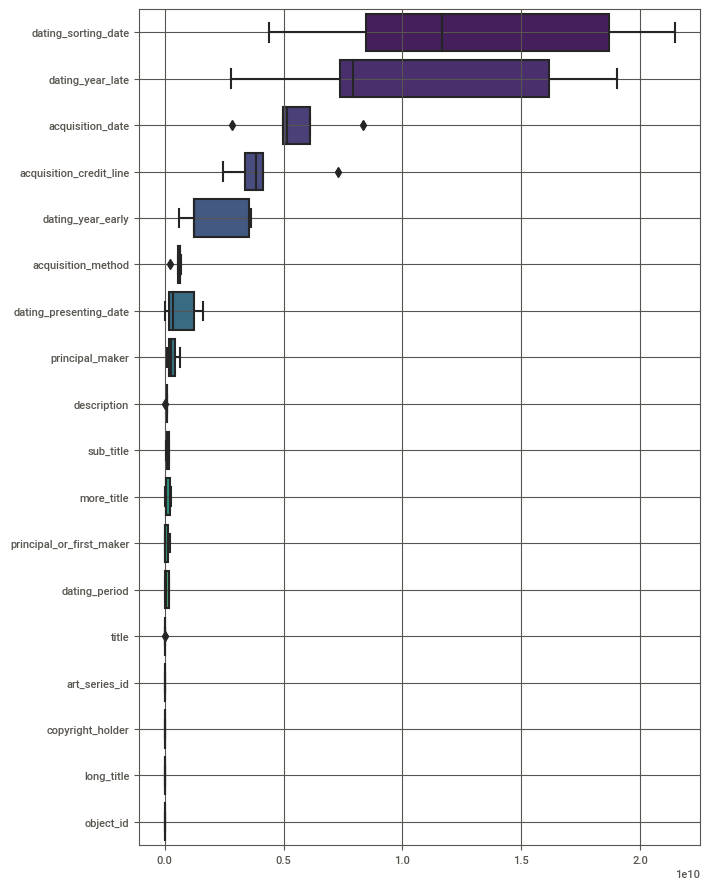

In [169]:
from fe import target_encoding
from lgbm import LGBM

lgbm = LGBM(train=train,
  test=test,
  target='likes',
  use_col=use_col,
  cat_col=cat_col,
  cfg=cfg,
  OUTPUT_DIR=OUTPUT_DIR,
  DO_FIT=True,
  DO_SEED_AVE=False,
  DEBUG=False)

feature_importance_df, order = lgbm.feature_importance()

In [170]:
from make_data import make_oof
oof_df = make_oof(OUTPUT_DIR=OUTPUT_DIR, TARGET=cfg['target'])

In [171]:
# from score import calc_macro_auc
# score = calc_macro_auc(train_target_df=train_target_df, oof_df=oof_df, order_list=TARGET_IDS)

In [176]:
sample_sub = pd.read_csv('../../data/atmacup10__sample_submission.csv')

In [199]:
from make_data import make_sub
sub_df = make_sub(sample_sub=sample_sub, TARGET_NAME=cfg['target'], TRIAL_NAME=TRIAL_NAME, OUTPUT_DIR=OUTPUT_DIR, cv_score=lgbm.score)

QUick Sub
sh sub.sh output/20210306015306_1_first_sub/pred/pred_likes_2.6164.csv


In [200]:
sub.head()

,likes
0,68.500677
1,9.184876
2,22.090073
3,68.801811
4,58.470058


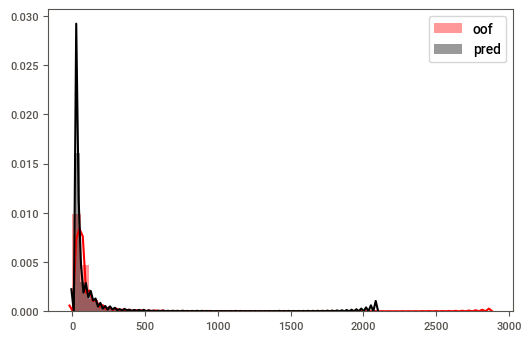

In [185]:
from make_fig import make_dist_oof_pred
make_dist_oof_pred(oof_df=oof_df,sub_df=sub_df,OUTPUT_DIR=OUTPUT_DIR)